In [1]:
#Script para identificar determinantes de citações na base USPTO
#Renato Kogeyama

#09-15-2019
#O naive bayes tem algum problema com distribuicoes desbalanceadas
#o scikit learn tem um modulo que corrige count distributions com muitos zeros, o complementNB
#porem este nao esta disponivel na atual versao disponibilizada no HPC da FIU

#09-10-2019
#o trabalho pede uma abordagem mais sistematica e cuidadosa
#estou agrupando o codigo antigo comentado e vou comecar um novo codigo

#09-17-2018

#Alto uso de memoria - rodar no Amazon AWS 
#Notebook 2

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from sklearn.metrics import roc_curve, auc
from scipy import stats
import datetime

In [3]:
# Read the file
# df=pd.read_table(r'/home/rkogeyam/PATENT_CITATION/df_w_pat_cit.csv', sep=',')

# o arquivo gerado em 190926 categoriza as variaveis type e kind, alem de trazer a data ja separada em dia, mes e ano
df=pd.read_csv(r'/home/rkogeyam/PATENT_CITATION/df_w_pat_cit_190926.csv', sep=',')

# Identify null variables
pd.isnull(df).sum() > 0

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id             False
type           False
number         False
country        False
date           False
abstract       False
title          False
kind           False
num_claims     False
filename       False
citation_id    False
year           False
month          False
day            False
dtype: bool

In [4]:
# Generate a binary output for simpler tests
df['citation_bi']=0
df.loc[df.citation_id>0, 'citation_bi']=1

# Convert categorical to binary
df=pd.get_dummies(df, columns=['type', 'kind'])

df.describe()

,num_claims,citation_id,year,month,day,citation_bi,type_TVPP,type_design,type_plant,type_reissue,...,kind_B2,kind_E,kind_E1,kind_H,kind_H1,kind_I5,kind_P,kind_P2,kind_P3,kind_S
count,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,...,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06,5.896209e+06
mean,1.539996e+01,3.124626e-01,2.002593e+03,6.588925e+00,1.563289e+01,2.163119e-02,5.088015e-07,3.731211e-06,4.161318e-03,2.948166e-03,...,4.908549e-01,1.472811e-03,1.475355e-03,3.358090e-04,4.477453e-05,5.088015e-07,1.404631e-03,1.909871e-03,8.468153e-04,3.731211e-06
std,1.182266e+01,5.538106e+00,1.142401e+01,3.400621e+00,8.826776e+00,1.454761e-01,7.133031e-04,1.931631e-03,6.437392e-02,5.421692e-02,...,4.999164e-01,3.834895e-02,3.838201e-02,1.832202e-02,6.691228e-03,7.133031e-04,3.745208e-02,4.366032e-02,2.908777e-02,1.931631e-03
min,0.000000e+00,0.000000e+00,1.976000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,0.000000e+00,1.995000e+03,4.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.400000e+01,0.000000e+00,2.005000e+03,7.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+01,0.000000e+00,2.013000e+03,1.000000e+01,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,8.870000e+02,2.592000e+03,2.017000e+03,1.200000e+01,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [5]:
# df.columns.values

In [6]:
df.shape

(5896209, 31)

In [7]:
# data exploration

# outcome: citation count or citation binary

# a criacao de df2 era essencialmente para tornar a distribuicao visualizavel
# ja nao eh mais necessaria

# exclude zeroes and ones
df2=df[df.citation_id>1]
df2.shape

(105578, 31)

In [8]:
%matplotlib inline
# df2.citation_id.hist()


In [9]:
# std_dev_cit_id=np.abs(stats.zscore(df2['citation_id']))

In [10]:
# drop outliers 
# drop the row when absolute zscore > 3 
# df2[(np.abs(stats.zscore(df2)) < 3).all(axis=1)] # too slow

# df3 foi criado para tentar lidar com os erros

# df3=df2._get_numeric_data()
df3=df._get_numeric_data()
df3.shape

(5896209, 24)

In [11]:
# df3 = df3[~df3.groupby('patent_id').transform( lambda x: abs(x-x.mean()) > 1.96*x.std()).values] #agrupa por patent_id, o que nao faz sentido nesse caso. Transform requer groupby para funcionar.
# std_dev, mean=df3.citation_id.std(), df3.citation_id.mean()

# preparacao para retirar outliers
mean=df3.mean(axis=0)
std_dev=df3.std(axis=0)

# threshold=3*std_dev.citation_id
threshold=3*std_dev

df3=df3[df3.citation_id-mean.citation_id<threshold.citation_id]
df3=df3[df3.num_claims-mean.num_claims<threshold.num_claims]

df3.shape

(5781354, 24)

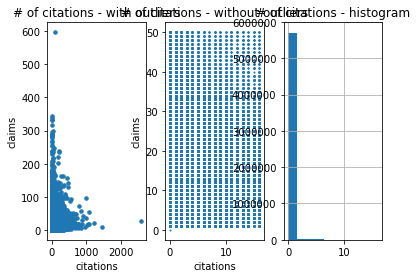

In [12]:
plot.subplot(1, 3, 1)
plot.title('# of citations - with outliers')
plot.xlabel('citations') 
plot.ylabel('claims') 
plot.scatter(df2['citation_id'], df2['num_claims'], s=12)

plot.subplot(1, 3, 2)
plot.title('# of citations - without outliers')
plot.xlabel('citations') 
plot.ylabel('claims') 
plot.scatter(df3['citation_id'], df3['num_claims'], s=1)

plot.subplot(1, 3, 3)
plot.title('# of citations - histogram')
df3.citation_id.hist()

plot.tight_layout() #diminui o overlap entre os graficos

In [13]:
# Check the Dataset
def uniqueColValues(auxdf):
    for column in auxdf:
        print("{} | {} | {}".format(
            auxdf[column].name, len(auxdf[column].unique()), auxdf[column].dtype
        ))
        
uniqueColValues(df2)

id | 105578 | object
number | 105578 | object
country | 1 | object
date | 2061 | object
abstract | 104170 | object
title | 100866 | object
num_claims | 212 | float64
filename | 2060 | object
citation_id | 486 | float64
year | 42 | int64
month | 12 | int64
day | 31 | int64
citation_bi | 1 | int64
type_TVPP | 1 | float64
type_design | 2 | float64
type_plant | 2 | float64
type_reissue | 2 | float64
type_statutory invention registration | 2 | float64
type_utility | 2 | float64
kind_A | 2 | float64
kind_B1 | 2 | float64
kind_B2 | 2 | float64
kind_E | 2 | float64
kind_E1 | 2 | float64
kind_H | 1 | float64
kind_H1 | 2 | float64
kind_I5 | 1 | float64
kind_P | 2 | float64
kind_P2 | 2 | float64
kind_P3 | 2 | float64
kind_S | 2 | float64


In [14]:
# # Naive Bayes

chosenColumns = ['num_claims','year']

myX = df2.as_matrix(columns=chosenColumns)
# myY = df2.as_matrix(columns=['citation_id'])
myY = df2.as_matrix(columns=['citation_id'])

xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
testSize = yTest.shape[0]


# nb = naive_bayes.GaussianNB()

# dado que o output eh count, uma distribuicao multinomial se adapta melhor
nb = naive_bayes.MultinomialNB()

# complementNB adapta o MultinomialNB para datasets muito desbalanceados
# porem nao esta disponivel para a versao 0.19 do scikit-learn
# nb = naive_bayes.ComplementNB()

nb.fit(xTrain, yTrain.ravel())

yPredNB = nb.predict(xTest) # predicting test data

# computing error
errorNB = np.sum((yPredNB[i] != yTest[i]) for i in range(0, testSize))
errorNBPCT = int(100*errorNB/testSize)
hitRateNBPCT = 100 - errorNBPCT

print("----------Naive Bayes----------")
print(int(errorNB), "misclassified data out of", testSize)
print("Error PCT: ",errorNBPCT,'%')
print("Hit Rate:  ",hitRateNBPCT,'%')

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


----------Naive Bayes----------
28095 misclassified data out of 31674
Error PCT:  88 %
Hit Rate:   12 %


In [15]:
# codigo descontinuado em 09-10-2019

# import pandas as pd
# import numpy as np

# from sklearn import naive_bayes
# # from sklearn.naive_bayes import ComplementNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plot
# from sklearn.metrics import roc_curve, auc
# import time


# # Este codigo foi parado em 09-16-2019. Serve para futura referencia.

# #To check when the script was last run
# localtime = time.localtime(time.time())
# print ("Local current time :", localtime)

# df=pd.read_table(r'/home/rkogeyam/PATENT_CITATION/df_w_pat_cit.csv', sep=',')

# # Just to adjust our plots inside Jupyter
# % matplotlib inline

# # df.describe()
# # np.any(np.isnan(df))

# # np.all(np.isfinite(mat))

# # df=df.dropna()


# # inds = np.where(np.isnan(df))

# #preciso cortar a base pq esta enorme e a memoria nao eh suficiente.
# # df2=df.sample(frac=0.1, random_state=1) #random_state permite reprodutibilidade

# #tentativa de resolver o NaN, infinite or too large value error.
# # df2=df.reset_index()
# # df2=df.replace([np.inf, -np.inf], np.nan)
# # df2=df2.dropna()
# # np.argwhere(np.isnan(df))
# # df.isnull().values.any()

# df.isnull().any().any()

# pd.isnull(df).sum() > 0

# df2=df.dropna()

# # df2=df2.drop(['type_statutory invention registration'], axis=1)

# df2.dtypes

# # #vamos procurar o ofensor, estilo calculo numerico
# # df2=df2.loc[:, 'id':'citation_id']
# #talvez o problema nao seja os dados, e sim o uso do script
# #vou examinar os dados mais de perto

# #plot simple correlation
# # plot.scatter(df['citation_id'], df['num_claims'])

# # df.hist()
# # plot.show()

# # corMat=df.corr()
# # plot.pcolor(corMat)
# # plot.show()

# # let's try a simplifying hypothesis
# # let the output become binary

# df2['citation_bi']=0
# df2.loc[df2.citation_id>0, 'citation_bi']=1

# df2.describe()

# chosenColumns = ['num_claims','year','month','day','type_TVPP','type_defensive publication','type_design','type_plant','type_reissue','kind_H','kind_H1','kind_H2','kind_I4','kind_I5','kind_P','kind_P2','kind_P3','kind_S','kind_S1']
# # chosenColumns = ['num_claims','year','month','day','type_TVPP']

# myX = df2.as_matrix(columns=chosenColumns)
# # myY = df2.as_matrix(columns=['citation_id'])
# myY = df2.as_matrix(columns=['citation_bi'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3)
# testSize = yTest.shape[0]

# # # Naive Bayes

# # nb = naive_bayes.GaussianNB()
# # dado que o output eh count, uma distribuicao multinomial se adapta melhor
# nb = naive_bayes.MultinomialNB()
# # complementNB adapta o MultinomialNB para datasets muito desbalanceados
# # porem nao esta disponivel para a versao 0.19 do scikit-learn
# # nb = naive_bayes.ComplementNB()

# nb.fit(xTrain, yTrain.ravel())

# yPredNB = nb.predict(xTest) # predicting test data

# # computing error
# errorNB = np.sum((yPredNB[i] != yTest[i]) for i in range(0, testSize))
# errorNBPCT = int(100*errorNB/testSize)
# hitRateNBPCT = 100 - errorNBPCT

# print("----------Naive Bayes----------")
# print(int(errorNB), "misclassified data out of", testSize)
# print("Error PCT: ",errorNBPCT,'%')
# print("Hit Rate:  ",hitRateNBPCT,'%')

# # # K Nearest Neighbors

# # myK = 5
    
# # knn =  KNeighborsClassifier(n_neighbors=myK)
# # knn.fit(xTrain, yTrain.ravel())
# # yPredKNN = knn.predict(xTest) # predicting test data

# # # computing error
# # errorKNN = np.sum((yPredKNN[i] != yTest[i]) for i in range(0, testSize))
# # errorKNNPCT = int(100*errorKNN/testSize)
# # hitRateKNNPCT = 100 - errorKNNPCT

# # print("----------K Nearest Neighbors----------")
# # print(int(errorKNN), "misclassified data out of", testSize)
# # print("Error PCT: ",errorKNNPCT,'%')
# # print("Hit Rate:  ",hitRateKNNPCT,'%')

# # Constructing the ROC curve and AUC

# fpr, tpr, thresh = roc_curve(yTest.ravel(), yPredKNN.ravel())
# rocAuc = auc(fpr, tpr)